In [ ]:
!pip install ucimlrepo pandas matplotlib scikit-learn

In [111]:
# ------- Import Dataset -------------------

from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets # unused?

# Combine Date and Time into a single DateTime column -> only 14 features
import pandas as pd

X['DateTime'] = pd.to_datetime(X['Date'] + ' ' + X['Time']) # Format (JJJJ-MM-DD HH:MM:SS, e.g.: 2004-03-10 18:00:00)
X = X.set_index('DateTime')
X.drop(['Date', 'Time'], axis=1, inplace=True)  # Remove the original Date and Time columns

In [ ]:
# Replace all -200 values with 0

X.replace(-200, 0, inplace=True)
X.replace(-200.0, 0, inplace=True)

In [104]:
# Replace all -200 values with 0
import numpy as np
X.replace(-200, np.nan, inplace=True)
X.replace(-200.0, np.nan, inplace=True)

In [ ]:
X.fillna(method='ffill', inplace=True)

In [ ]:
# X.rename(columns={'PT08.S1(CO)': 'CO(PT08.S1)'})
# X.rename(columns={'PT08.S2(NMHC)': 'NMHC(PT08.S2)'})
# X.rename(columns={'PT08.S3(NOx)': 'NOx(PT08.S3)'})
# X.rename(columns={'PT08.S4(NO2)': 'NO2(PT08.S4)'})
# X.rename(columns={'PT08.S5(O3)': 'O3(PT08.S5)'})

In [108]:
# Create second numpy dataframe without "-200" values
import numpy as np
X2 = X.copy()
X2.replace(-200, np.nan, inplace=True)
X2.replace(-200.0, np.nan, inplace=True)

In [ ]:
pd.set_option('display.width', 1000)
print(X.head())

In [ ]:
# Plot all features over a Date-Time axis
import matplotlib.pyplot as plt

for feature in X.columns:
    plt.figure(figsize=(23, 4))
    plt.plot(X.index, X[feature])
    plt.title(feature)
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.show()

In [ ]:
# Plot all features over a Date-Time axis till a specific value
import matplotlib.pyplot as plt

cutoff_date = pd.to_datetime('2004-04-10')

for feature in X.columns:
    plt.figure(figsize=(23, 4))
    
    # Filter the DataFrame to include only data up to the cutoff date
    filtered_data = X.loc[:cutoff_date, feature]

    plt.plot(filtered_data.index, filtered_data)
    plt.title(feature)
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.show()

In [ ]:
# Plot two features together over a DateTime axis
# Observation: The sensor measuring the same values differ in amplitude -> maybe need to be normalized
feature_pairs = [
    ('CO(GT)', 'PT08.S1(CO)'),      # Carbon Monoxid
    ('NMHC(GT)', 'PT08.S2(NMHC)'),  # Non Metanic Hyrdo Carbons
    ('NOx(GT)', 'PT08.S3(NOx)'),    # Nitrogen Oxides -> Nitric Oxide (NO) + Nitrogen Dioxide (NO2)
    ('NO2(GT)', 'PT08.S4(NO2)'),    # Nitrogen Dioxide
]

for feature1, feature2 in feature_pairs:
  plt.figure(figsize=(20, 4))
  plt.plot(X.index, X[feature1], label=feature1)
  plt.plot(X.index, X[feature2], label=feature2)
  plt.title(f'{feature1} and {feature2} over Time')
  plt.xlabel('DateTime')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

In [ ]:
# Plot two features together over a DateTime axis but normalize them and remove "-200" values
# Observation: After normalizing the pair features, the two sensors often differ from each other. Here is probaly some kind of systemic error in the features. -> maybe temperatur dependat???
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

feature_pairs = [
    ('CO(GT)', 'PT08.S1(CO)'),
    ('NMHC(GT)', 'PT08.S2(NMHC)'),
    ('NOx(GT)', 'PT08.S3(NOx)'),
    ('NO2(GT)', 'PT08.S4(NO2)'),
]

# Create a Min-Max Scaler instance
scaler = MinMaxScaler()

for feature1, feature2 in feature_pairs:
    plt.figure(figsize=(20, 4))

    # Select the features and drop NaN values for consistent scaling
    pair_data = X2[[feature1, feature2]].dropna()

    # Apply Min-Max scaling
    scaled_data = scaler.fit_transform(pair_data)

    # Plot the normalized features
    plt.plot(X2.index[X2.index.isin(pair_data.index)], scaled_data[:, 0], label=f'Normalized {feature1}')
    plt.plot(X2.index[X2.index.isin(pair_data.index)], scaled_data[:, 1], label=f'Normalized {feature2}')
    plt.title(f'Normalized {feature1} and {feature2} over Time')
    plt.xlabel('DateTime')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.show()

In [ ]:
# Plot all features within a 24h range while averaging over a year
# Observation: -> 7-10 am spike and 5-8 pm spike -> most trafic
import numpy as np
import matplotlib.pyplot as plt

X2['Hour'] = X2.index.hour
hourly_means = X2.groupby('Hour').mean()

for feature in hourly_means.columns:
    if feature != 'Hour':  # Exclude the hour column from plotting
        plt.figure(figsize=(23, 4))
        plt.plot(hourly_means.index, hourly_means[feature], marker='o')  # Changed to line plot with markers
        plt.title(f'{feature}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Value')
        plt.xticks(range(24))  # Ensure all hours are shown
        plt.grid(True)  # Optional: Adds a grid for better readability
        plt.show()


In [ ]:
# Plot all recorded days and take an average of 24h
# Observation: There are lots of small round peaks. These are the weeks
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X is your DataFrame and the index is a datetime index
# Resample the data by day and calculate the mean
daily_means = X.resample('D').mean()

# Plotting
for feature in daily_means.columns:
    plt.figure(figsize=(23, 4))
    plt.plot(daily_means.index, daily_means[feature], marker='o')
    plt.title(f'Daily Average of {feature}')
    plt.xlabel('Day')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.grid(True)
    plt.show()

In [ ]:
# Plot 24h average considering public holidays in italy
!pip install holidays
import matplotlib.pyplot as plt
import pandas as pd
import holidays

daily_means = X.resample('D').mean()

# List of holidays in Italy for 2004 and 2005
it_holidays = holidays.Italy(years=[2004, 2005])

# Plotting
for feature in daily_means.columns:
    plt.figure(figsize=(23, 4))

    # Plot the entire series as a line
    plt.plot(daily_means.index, daily_means[feature], label=f'Daily Average of {feature}', marker='o', color='blue')

    # Overlay markers for public holidays
    for day in daily_means.index:
        if day in it_holidays:
            plt.plot(day, daily_means.loc[day, feature], marker='o', color='red')

    plt.title(f'Daily Average of {feature}')
    plt.xlabel('Day')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# ------- Import Dataset -------------------

from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets # unused?

# Combine Date and Time into a single DateTime column -> only 14 features
import pandas as pd

X['DateTime'] = pd.to_datetime(X['Date'] + ' ' + X['Time']) # Format (JJJJ-MM-DD HH:MM:SS, e.g.: 2004-03-10 18:00:00)
X = X.set_index('DateTime')
X.drop(['Date', 'Time'], axis=1, inplace=True)  # Remove the original Date and Time columns

In [112]:
# Invert PT08.S3(NOx)
# X['PT08.S3(NOx)'] = -1 * X['PT08.S3(NOx)']  # Reversing the sign

# max_value = X['PT08.S3(NOx)'].max()
X2['PT08.S3(NOx)'] = 1719 - X['PT08.S3(NOx)']

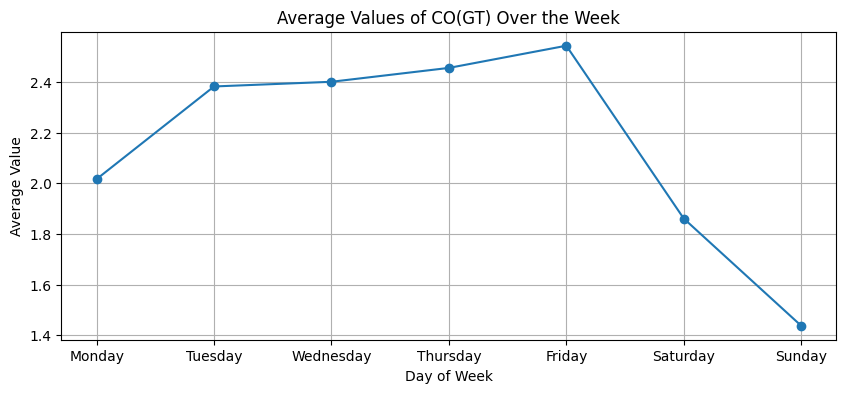

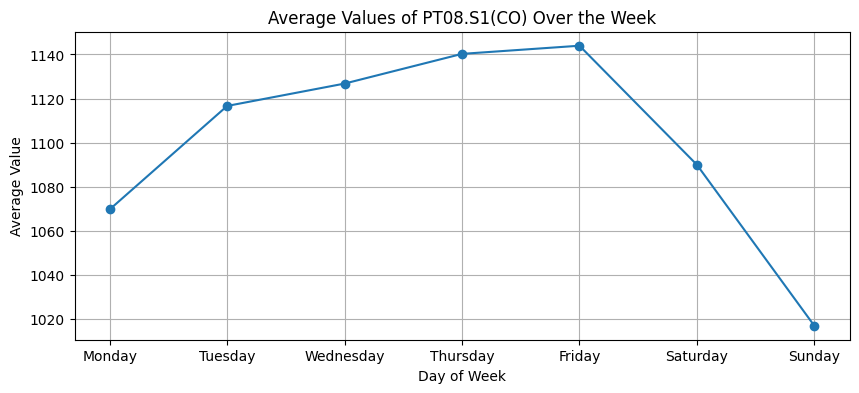

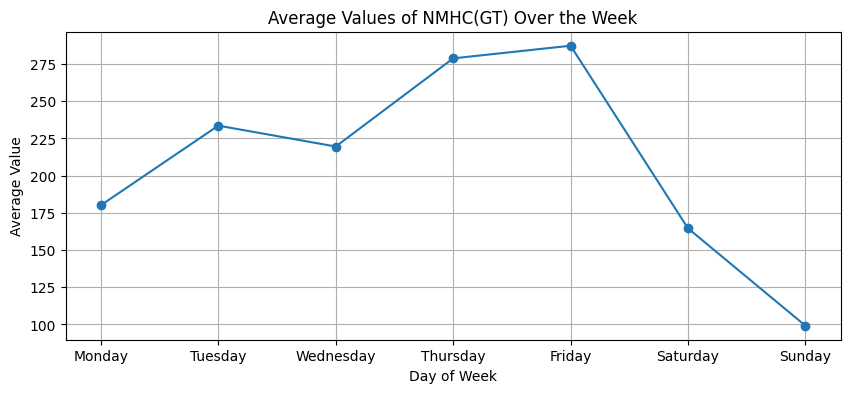

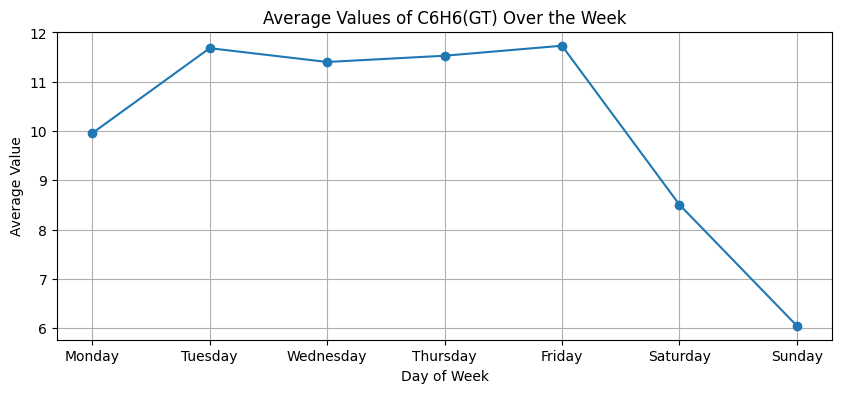

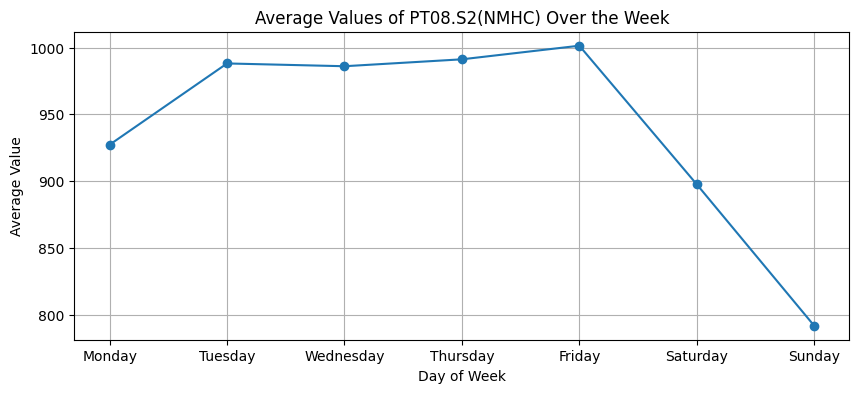

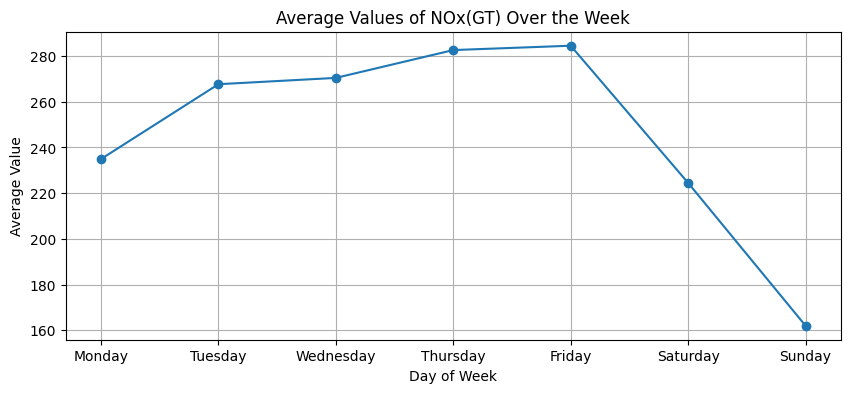

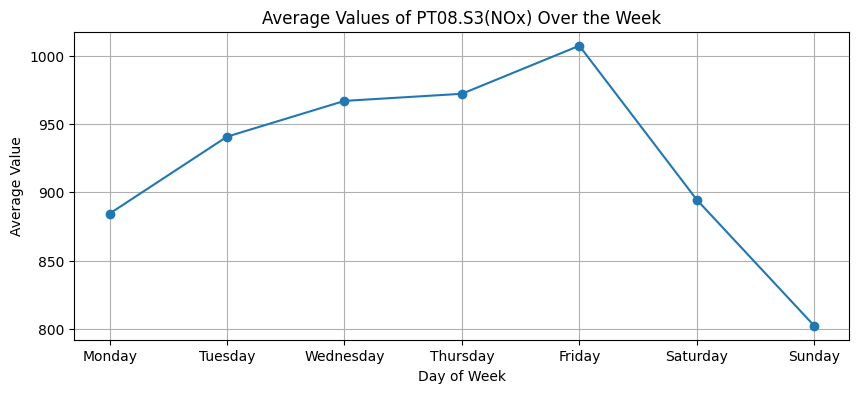

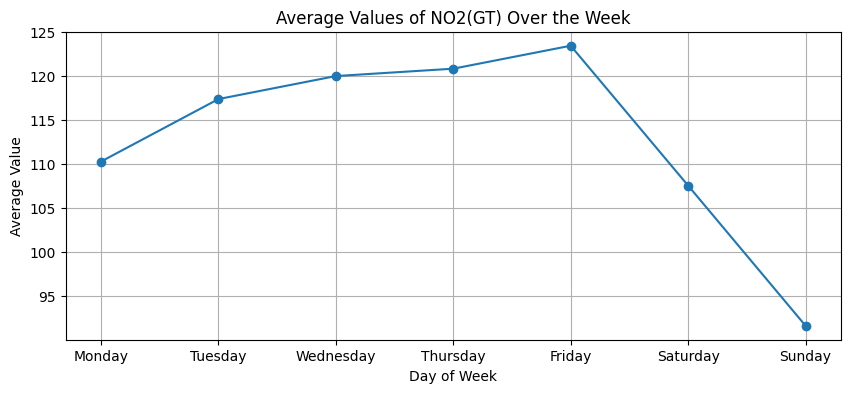

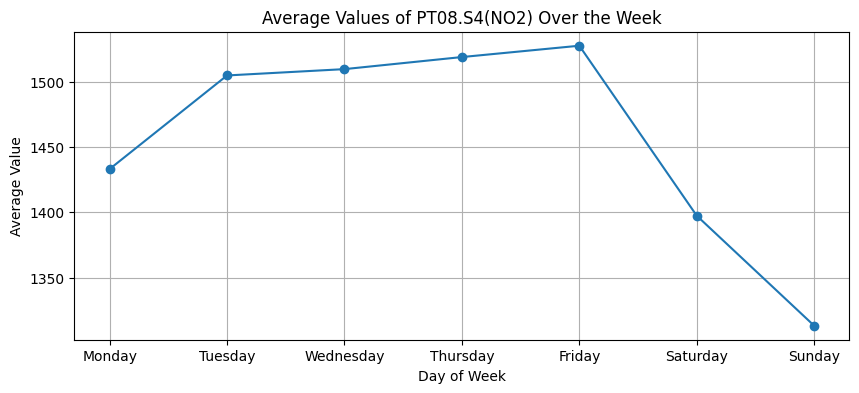

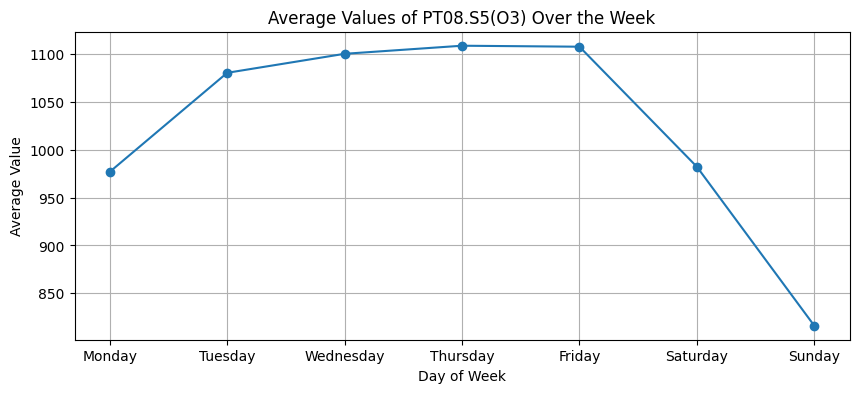

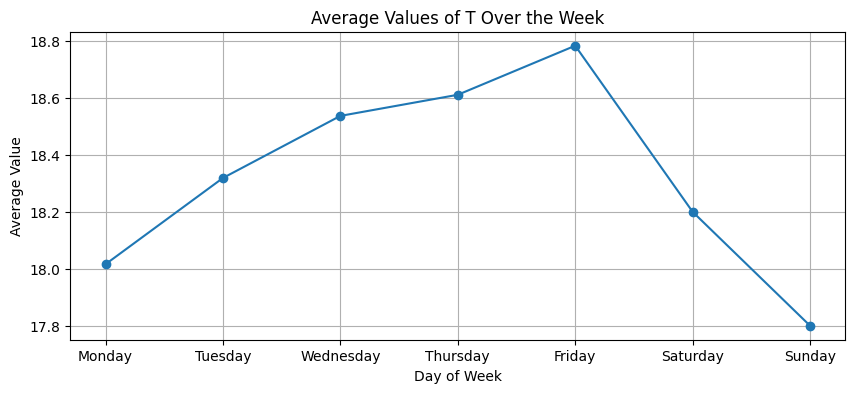

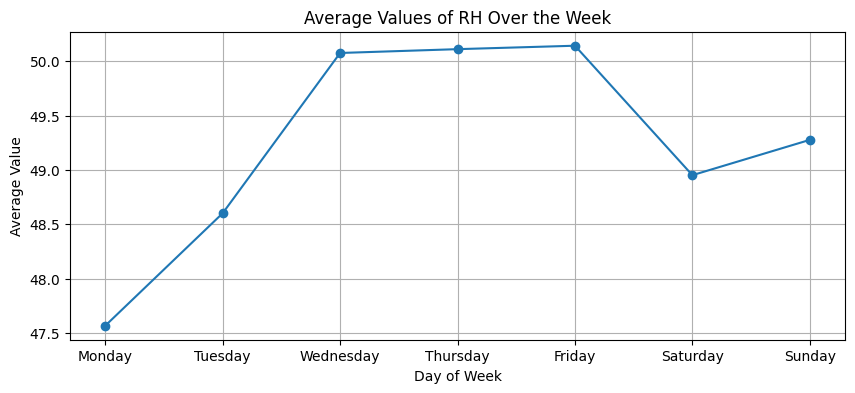

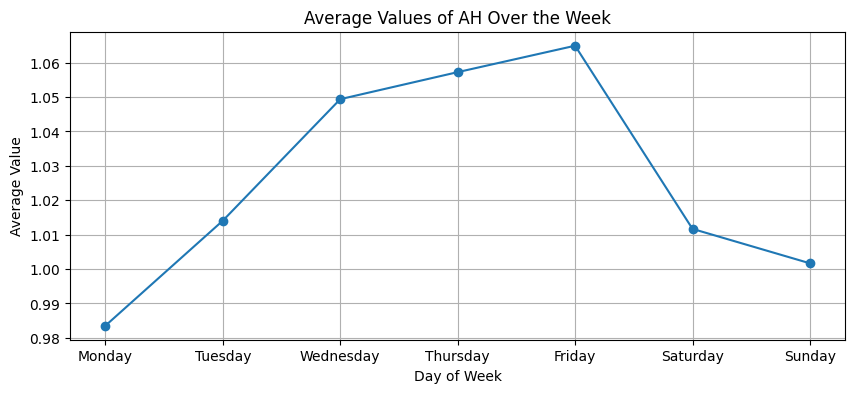

In [113]:
# Plot all features within 24h, while seperating week day (aferage over 52 values/weeks -> 24h * 7days)
# Observation: Sunday is the least polution, Saturday is also less compared to all the other days.
# Observation: One of the two NOx sensor shows inverse values for the week days compared to the other NOx sensor and all the other sensors covering polution -> sunday most, friday least -> WHY???
import matplotlib.pyplot as plt

X2['DayOfWeek'] = X2.index.dayofweek
daily_means = X2.groupby('DayOfWeek').mean()

import matplotlib.pyplot as plt

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for feature in daily_means.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(days, daily_means[feature], marker='o')
    plt.title(f'Average Values of {feature} Over the Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Value')
    plt.xticks(days)
    plt.grid(True)
    plt.show()

In [ ]:
# Plot an average of for each feature over an hour axis but seperate by week day
# Observation: Spike between 7-9 am and 5-8 pm, sunday and saturday less
# Observation: PT08.S3(NOx) Sunday the most polution -> further indication that high and low values are reversed!!!
import matplotlib.pyplot as plt
import numpy as np

X2['DayOfWeek'] = X2.index.dayofweek
X2['Hour'] = X2.index.hour

daily_hourly_means = X2.groupby(['DayOfWeek', 'Hour']).mean()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for feature in daily_hourly_means.columns:
    plt.figure(figsize=(15, 5))
    for day in range(7):  # 0 is Monday, 6 is Sunday
        day_data = daily_hourly_means.loc[day]
        plt.plot(np.arange(24), day_data[feature], label=days[day], marker='o')
    plt.title(f'Hourly Average Values of {feature} Over the Week')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    plt.xticks(np.arange(24))
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Plot an average of each feature for each week of the year -> maybe more on christmas...
# Observation: in the winter-month, when the temperatur is lower, the polution is higher
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Calculate WeekOfYear and ensure it's an integer
X2['WeekOfYear'] = X2.index.isocalendar().week.astype(int)
weekly_means = X2.groupby('WeekOfYear').mean()

# Plotting
for feature in weekly_means.columns:
    plt.figure(figsize=(23, 4))
    plt.plot(weekly_means.index, weekly_means[feature], marker='o')
    plt.title(f'Average Weekly Values of {feature}')
    plt.xlabel('Week of the Year')
    plt.ylabel('Average Value')

    # Handling x-ticks
    x_ticks = weekly_means.index.unique()
    plt.xticks(x_ticks, rotation=45)  # Set x-ticks to unique values of WeekOfYear

    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_pairs = [
    ('CO(GT)', 'PT08.S1(CO)'),      # Carbon Monoxide
    ('NMHC(GT)', 'PT08.S2(NMHC)'),  # Non-Metanic Hydro Carbons
    ('NOx(GT)', 'PT08.S3(NOx)'),    # Nitrogen Oxides
    ('NO2(GT)', 'PT08.S4(NO2)'),    # Nitrogen Dioxide
]

# Define the rolling window size
window_size = 30  # e.g., 30 days

for feature1, feature2 in feature_pairs:
    plt.figure(figsize=(20, 4))

    # Calculate rolling correlation
    rolling_corr = X[[feature1, feature2]].rolling(window=window_size).corr().unstack()[feature1][feature2]

    # Plot the rolling correlation
    plt.plot(rolling_corr, label=f'Rolling Correlation ({window_size}-day window)')
    plt.title(f'Rolling Correlation between {feature1} and {feature2} over Time')
    plt.xlabel('DateTime')
    plt.ylabel('Rolling Correlation')
    plt.legend()
    plt.show()